In [1]:
import os.path
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation
import threading
import pickle
import joblib
import copy
import threading
from sklearn import impute, preprocessing, model_selection, base, metrics, linear_model, pipeline, ensemble, svm, multiclass, neighbors, compose, datasets, decomposition, manifold, cluster, mixture
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import cv2
from custom_objects import decorators
import gym
import pygame as pg
import nltk
from  nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize
from matplotlib.ticker import FixedLocator, FixedFormatter

**Loading the data**
Let us load the data from sklearn datasets. Then, we split it into a train, test and validation set. Note that I have used stratified sampling because the size of the dataset is pretty small.

In [2]:
olivetti = datasets.fetch_olivetti_faces()

In [3]:
X, y = olivetti.get('data'), olivetti.get('target')

In [84]:
X_train, X_test, y_train ,y_test = model_selection.train_test_split(X, y, train_size=0.65, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_test, y_test, train_size=0.6, stratify=y_test)

In [9]:
X_train.shape, y_train.shape

((260, 4096), (260,))

**Look at the data**

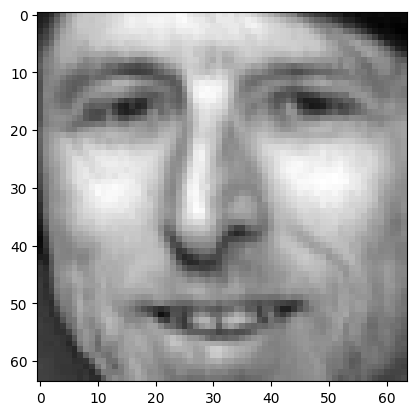

In [10]:
plt.imshow(X_train[0].reshape(-1,64), cmap='gray')

In [11]:
def draw_faces(batch, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(columns*3, rows*3))
    for image, axis in zip(batch, axes.flat):
        image = image.reshape(64,64)
        axis.imshow(image, cmap='gray')
        axis.axis('off')

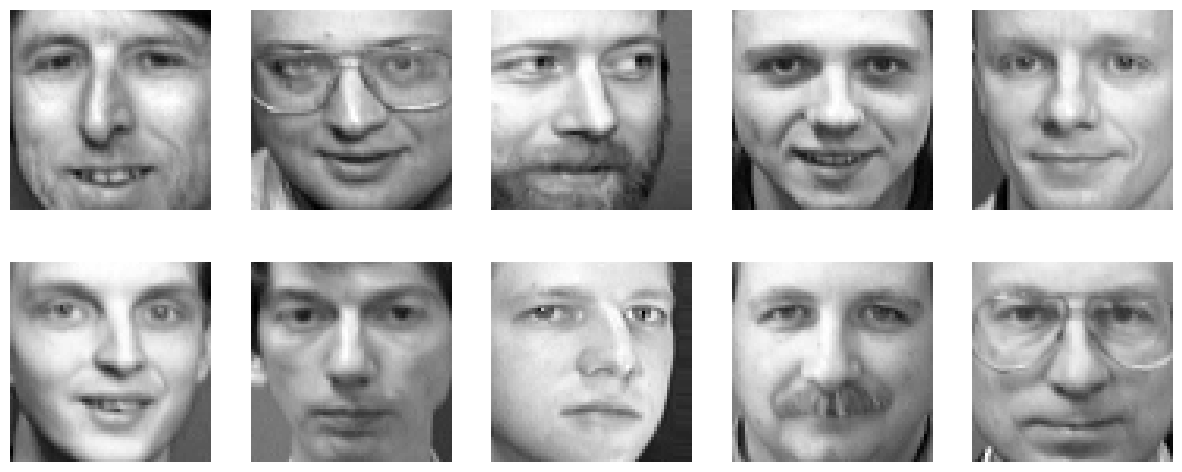

In [12]:
draw_faces(X_train, 2, 5)

We do not need to scale or center the dataset as it is already scaled.

In [15]:
np.max(X_train), np.min(X_train)

(1.0, 0.0)

Although we know that there are 10 different classes, let us assume we don't for clustering. I am going to cluster the train-set using KMeans with 10 different values of ``k``, and ``llyod`` algorithm and default initialization. Since the dataset is small, I can loop over it 10 times as KMeans is itself a fast enough algorithm.

In [ ]:
inertias = []

for k in range(10, 100, 2):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

Text(0, 0.5, 'Inertia')

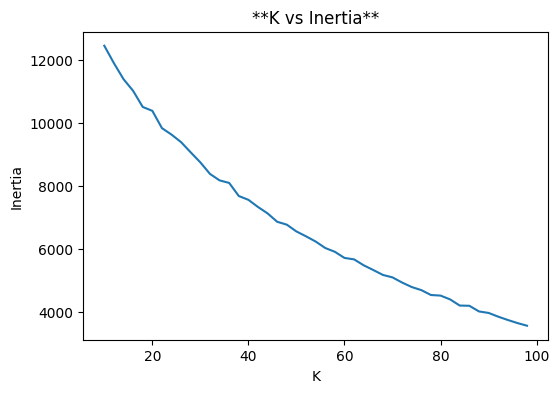

In [36]:
ks = range(10, 100, 2)
fig = plt.figure(figsize=(6,4))
plt.plot(ks, inertias)
plt.title('**K vs Inertia**')
plt.xlabel('K')
plt.ylabel('Inertia')

Okay, looks like ``inertia_`` does not help much. It keeps on getting smaller and smaller as we increase **k**, which is the expected behaviour. Let us try and get a better evaluation using **silhoutte analysis**.

In [66]:
kmeans_per_k = [cluster.KMeans(n_clusters=k, random_state=42).fit(X_train)
                for k in range(10, 100, 2)]
silhouette_scores = [metrics.silhouette_score(X_train, model.labels_) for model in kmeans_per_k]

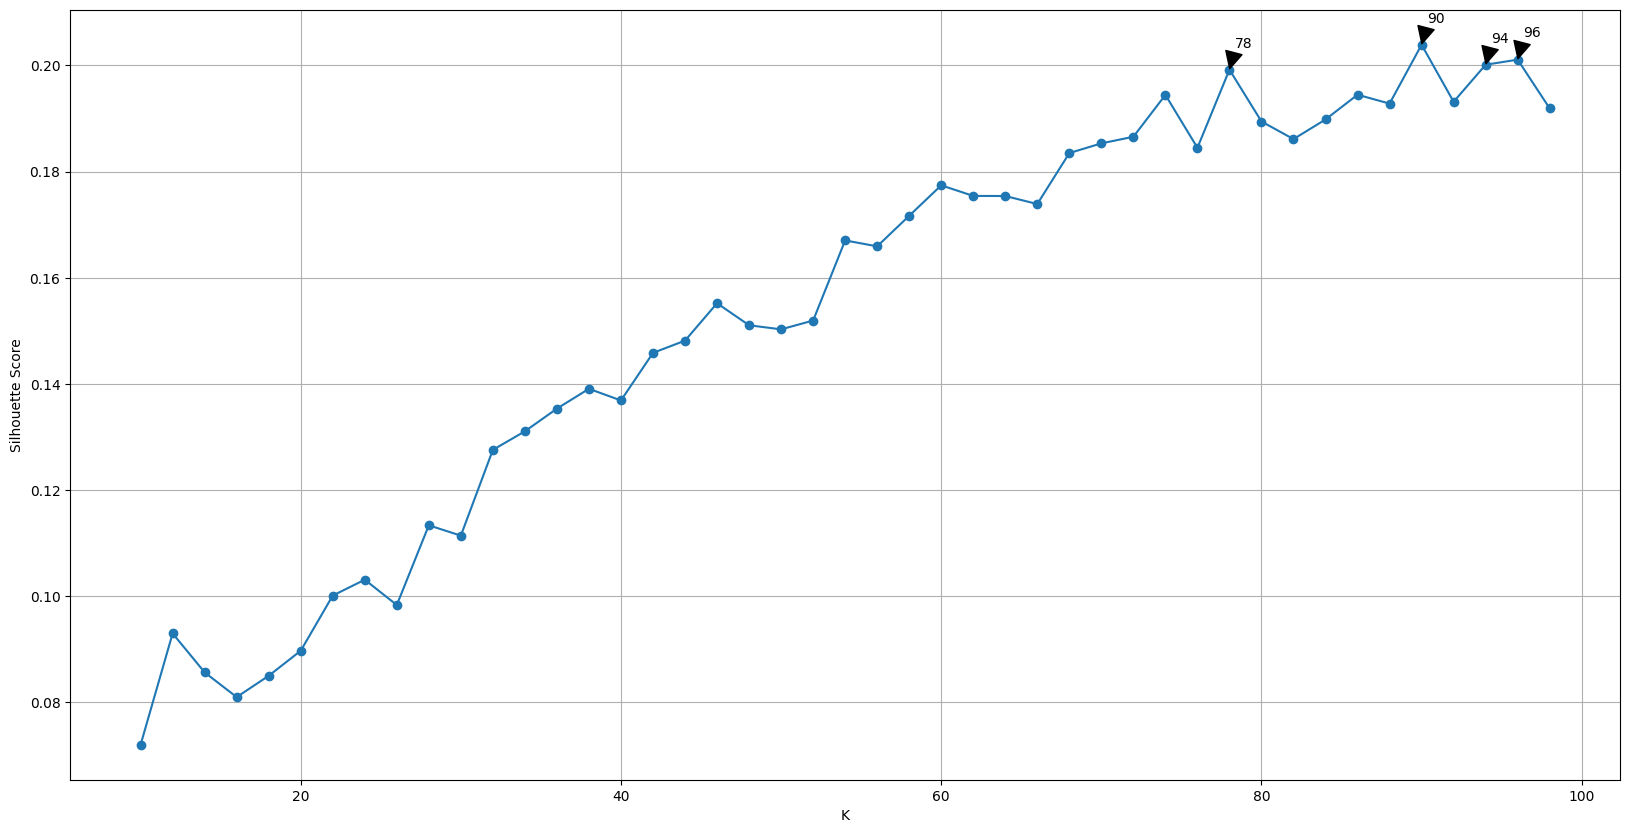

In [87]:
# Plot the silhouette scores
plt.figure(figsize=(20, 10))
plt.plot(ks, silhouette_scores, 'o-')  # 'o-' adds circle markers to the line
plt.grid()
plt.xlabel('K')
plt.ylabel('Silhouette Score')

# Find the four highest silhouette scores and their corresponding k values
highest_scores = sorted(zip(silhouette_scores, ks), reverse=True)[:4]

# Annotate the four highest points
for score, k in highest_scores:
    plt.annotate(k,
                 xy=(k, score),
                 xytext=(10, 14),  # Slight offset to avoid overlapping the point
                 textcoords='offset points',
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 horizontalalignment='center', verticalalignment='bottom')

plt.show()

The highest **Sihouette Scores** occur at k=78, k=90, k=94 and k=96 and the scores start dropping as k approaches 100. We could draw a Silhouette diagram to analyse these points closely, but since the value of k is very high, and the difference between scores negligible, let us go with the highest score, i.e., **k=90**.

**KMeans as Preprocessing Step**

Next, let us try to train a Random Forest Classifier on our data. We will then see how are the scores affected if we use KMeans as a dimensionality reduction step before RF.

In [104]:
rf_clf = ensemble.RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_clf.score(X_val, y_val)

0.9404761904761905

In [107]:
rf_clf.score(X_train, y_train)

1.0

Note that we are going to ignore the fact that the model (or any other model that we will see in this notebook) is overfitting like crazy. That is because it common for any model to overfit a dataset as small as our (260 samples only), specially when the number of features is comparatively huge (4096). So, from now on we shall only focus on validation errors.

Let us transform the dataset into just below 100 features with KMeans before feeding into RF.

In [99]:
pipe = pipeline.Pipeline([('kmeans', cluster.KMeans()),
                          ('rf_clf', ensemble.RandomForestClassifier())])

In [100]:
params = {'kmeans__n_clusters':[78, 90, 94, 96]}

grid_search = model_selection.GridSearchCV(pipe, param_grid=params, cv=5, return_train_score=True)

In [101]:
grid_search.fit(X_train, y_train)

C:\Users\thory\miniconda3\envs\small-projects-ml\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\thory\miniconda3\envs\small-projects-ml\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\thory\miniconda3\envs\small-projects-ml\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\thory\miniconda3\envs\small-projects-ml\lib\site-packages\sklearn\cluster\_kmeans.py:1416: Fut

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('kmeans', KMeans()),
                                       ('rf_clf', RandomForestClassifier())]),
             param_grid={'kmeans__n_clusters': [78, 90, 94, 96]},
             return_train_score=True)

In [108]:
grid_search.best_score_

0.7769230769230769

In [109]:
grid_search.score(X_val, y_val)

0.8928571428571429

**Gaussian Mixture Models**

In the following cells, I am going to train a GMM on faces dataset and generate some new faces. But before that, just to speed things up, let me just compress the dataset slightly using PCA.

In [5]:
pca = decomposition.PCA(n_components=0.99)
gmm = mixture.GaussianMixture(n_components=50, n_init=5, random_state=42)

In [6]:
X_train_c = pca.fit_transform(X_train)
X_val_c = pca.transform(X_val)

In [7]:
gmm.fit(np.r_[X_train_c])

GaussianMixture(n_components=50, n_init=5, random_state=42)

In [8]:
faces = gmm.sample(n_samples=4)

In [9]:
printable_faces = []
for face in faces[0]:
    face = pca.inverse_transform(face).reshape(64,64)
    printable_faces.append(face)

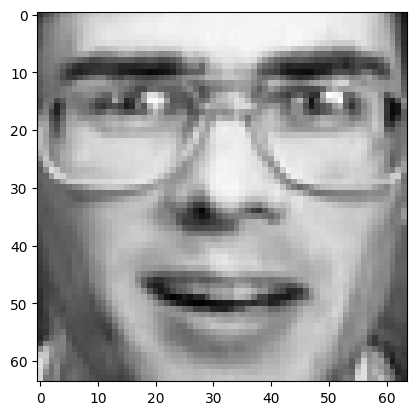

In [83]:
plt.imshow(printable_faces[3], cmap='gray')

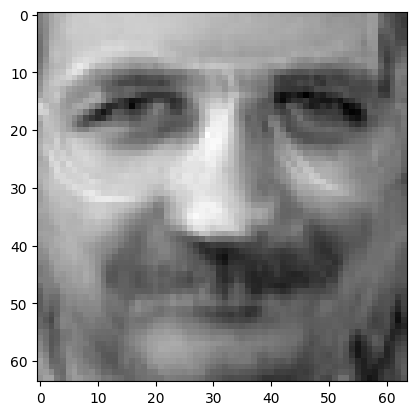

In [11]:
plt.imshow(printable_faces[1], cmap='gray')

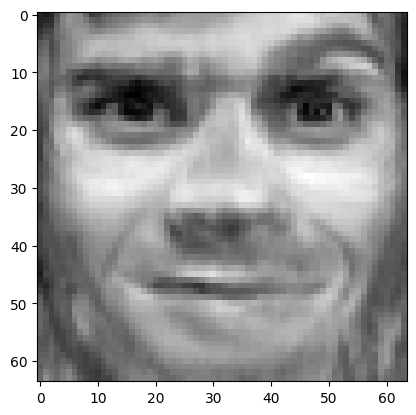

In [12]:
plt.imshow(printable_faces[2], cmap='gray')

**Anomaly Detection using GMM**

Let us now modify some of the images, and see if our GMM can classify them as anomalies.

In [13]:
mdf_idx = [i for i in range(1, 260, 40)]
mdf_idx

[1, 41, 81, 121, 161, 201, 241]

In [86]:
anomaly_faces = []
for i, idx in enumerate(mdf_idx):
    anomaly_faces.append(X_train[idx, ::-1])

anomaly_faces = np.array(anomaly_faces)

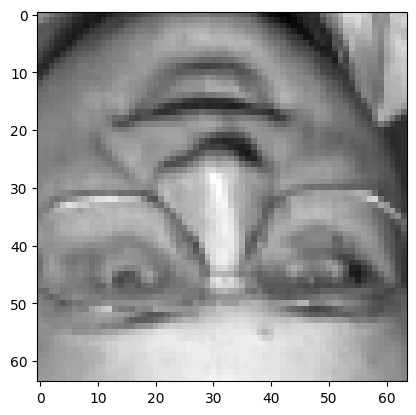

In [79]:
plt.imshow(anomaly_faces[0].reshape(64,64), cmap='gray')

In [71]:
X_train_c = pca.fit_transform(X_train)
gmm.fit(X_train_c)

GaussianMixture(n_components=50, n_init=5, random_state=42)

In [72]:
# Scores on actual dataset
scores = gmm.score_samples(X_train_c)

array([1053.25479314, 1017.64023469, 1045.99072656, 1072.77032864,
       1067.78785638, 1051.39711883, 1053.25479134, 1051.39711851,
       1045.99073057, 1045.99072685, 1060.13296299, 1075.30193648,
       1072.77032818, 1060.31922129, 1105.29925188, 1068.81058434,
       1097.37429812, 1089.52215376, 1120.33686658, 1112.42617518,
       1097.18819042, 1052.64952394, 1105.33833767, 1073.87069059,
       1097.36979454, 1060.13295293, 1104.21213575, 1097.37429818,
       1073.87069018, 1104.41997393, 1073.95405603, 1081.70391239,
       1081.70391338, 1053.254791  , 1080.77601628, 1080.77601585,
       1111.93779223, 1089.33096989, 1017.6401511 , 1066.17426859,
       1104.41997393, 1052.64952904, 1017.64015061, 1080.90975074,
       1017.64014855, 1080.90975081, 1073.8706905 , 1051.39712345,
       1073.87069045, 1045.99073351, 1073.95405755, 1112.67150027,
       1066.17426839, 1060.31921875, 1082.0787571 , 1067.78786841,
       1072.77032864, 1088.40155238, 1051.39712017, 1067.78785

In [82]:
anomaly_faces_c = pca.transform(anomaly_faces)
gmm.score_samples(anomaly_faces_c)

array([-37042965.27014134, -27594409.38916874, -30806019.0053204 ,
       -36249099.92469345, -45735890.85620619, -46478608.50266388,
       -30507473.74977192])

As we can see, the anomalies have way lower densities than the original faces.

**Anomaly Detection using Dimensionality Reduction Techniques**

In [88]:
X_train_c = pca.fit_transform(X_train)
anomaly_faces_c = pca.transform(anomaly_faces)

In [89]:
reconstructed_X_train = pca.inverse_transform(X_train_c)
reconstruction_error_orgi = np.square((X_train - reconstructed_X_train).mean())

In [91]:
reconstruction_error_orgi

1.8717707e-19

In [92]:
reconstructed_anomaly = pca.inverse_transform(anomaly_faces_c)
reconstruction_error_anomaly = np.square(anomaly_faces - reconstructed_anomaly).mean()

In [93]:
reconstruction_error_anomaly

0.0068712193

Clearly, **reconstruction error** for anomalies is way higher than that of actual faces, as should be the case.